# Vision Transformer

# **1. Dataset Preperartion Below:-**

In [1]:
!pip install transformers tensorflow

**Necessary modules**

In [ ]:
# modules needed for the code
from transformers import TFViTModel
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import transforms, models
from torchvision.datasets import CIFAR10
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from torch.utils.data.sampler import WeightedRandomSampler
import torch.nn.functional as F

In [3]:
# Here I am loading CIFAR 10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# 4000 samples for 10000 for testing
def select_subset(images, labels, num_samples):
    selected_indices = np.random.choice(len(images), num_samples, replace=False)
    return images[selected_indices], labels[selected_indices]

train_images, train_labels = select_subset(train_images, train_labels, num_samples=4000)
test_images, test_labels = select_subset(test_images, test_labels, num_samples=1000)

# Resize CIFAR-10 images from 32x32 to 224x224 and normalize pixel values
IMAGE_SIZE = 224
train_images = tf.image.resize(train_images, (IMAGE_SIZE, IMAGE_SIZE)).numpy() / 255.0
test_images = tf.image.resize(test_images, (IMAGE_SIZE, IMAGE_SIZE)).numpy() / 255.0

# split the test into test and validation set
test_images, val_images, test_labels, val_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42
)

# forming the dataset
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(BATCH_SIZE).shuffle(1000)
validation_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# **2. Standard Vision Transformer Model**

In [4]:
class VisionTransformerLayer(layers.Layer):
    def __init__(self, transformer_model, **kwargs):
        super(VisionTransformerLayer, self).__init__(**kwargs)
        self.transformer_model = transformer_model

    def call(self, inputs):
        # inputs to the expected formats
        inputs = tf.transpose(inputs, [0, 3, 1, 2])
        transformer_output = self.transformer_model(pixel_values=inputs).last_hidden_state[:, 0]
        return transformer_output

    def get_config(self):
        config = super().get_config()
        config.update({
            "transformer_model": self.transformer_model.name_or_path
        })
        return config

**build vit model**

In [5]:
def build_vit_model(num_classes):
    # Load pretrained Vision Transformer from Hugging Face
    transformer_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
    input_layer = tf.keras.Input(shape=(224, 224, 3))
    transformer_output = VisionTransformerLayer(transformer_model)(input_layer)
    output_layer = layers.Dense(num_classes, activation="softmax")(transformer_output)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

**train and compile vit model**

In [6]:
def train_vit_model(model, train_data, validation_data, model_name, epochs=20):
    checkpoint_callback = ModelCheckpoint(
        filepath=f"{model_name}_best.keras", save_best_only=True, monitor="val_accuracy", verbose=1
    )

    # Compilation of the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    training_history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[checkpoint_callback],
        verbose=2
    )

    if "accuracy" in training_history.history and "val_accuracy" in training_history.history:
        train_accuracy = [acc * 100 for acc in training_history.history["accuracy"]]
        val_accuracy = [acc * 100 for acc in training_history.history["val_accuracy"]]
        print("Training Accuracy at each epoch (%):", train_accuracy)
        print("Validation Accuracy at each epoch (%):", val_accuracy)
    else:
        print("No accuracy metrics recorded. Check dataset or model configuration.")

    return training_history


In [7]:
#Train the vit model for 20 epochs
print("Training Vision Transformer Model...")
vision_transformer_model = build_vit_model(num_classes=10)
training_history_vit = train_vit_model(
    vision_transformer_model, train_dataset, validation_dataset, "vision_transformer_model", epochs=20)

Training Vision Transformer Model...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.45000, saving model to vision_transformer_model_best.keras
125/125 - 43s - 345ms/step - accuracy: 0.2360 - loss: 2.2026 - val_accuracy: 0.4500 - val_loss: 2.0365
Epoch 2/20

Epoch 2: val_accuracy improved from 0.45000 to 0.72600, saving model to vision_transformer_model_best.keras
125/125 - 4s - 31ms/step - accuracy: 0.6223 - loss: 1.8878 - val_accuracy: 0.7260 - val_loss: 1.7465
Epoch 3/20

Epoch 3: val_accuracy improved from 0.72600 to 0.81000, saving model to vision_transformer_model_best.keras
125/125 - 4s - 31ms/step - accuracy: 0.7822 - loss: 1.6168 - val_accuracy: 0.8100 - val_loss: 1.5016
Epoch 4/20

Epoch 4: val_accuracy improved from 0.81000 to 0.85200, saving model to vision_transformer_model_best.keras
125/125 - 4s - 31ms/step - accuracy: 0.8307 - loss: 1.3908 - val_accuracy: 0.8520 - val_loss: 1.2998
Epoch 5/20

Epoch 5: val_accuracy improved from 0.85200 to 0.87000, saving model to vision_transformer_model_best.ker

**prediction on the test images for ViT Model**

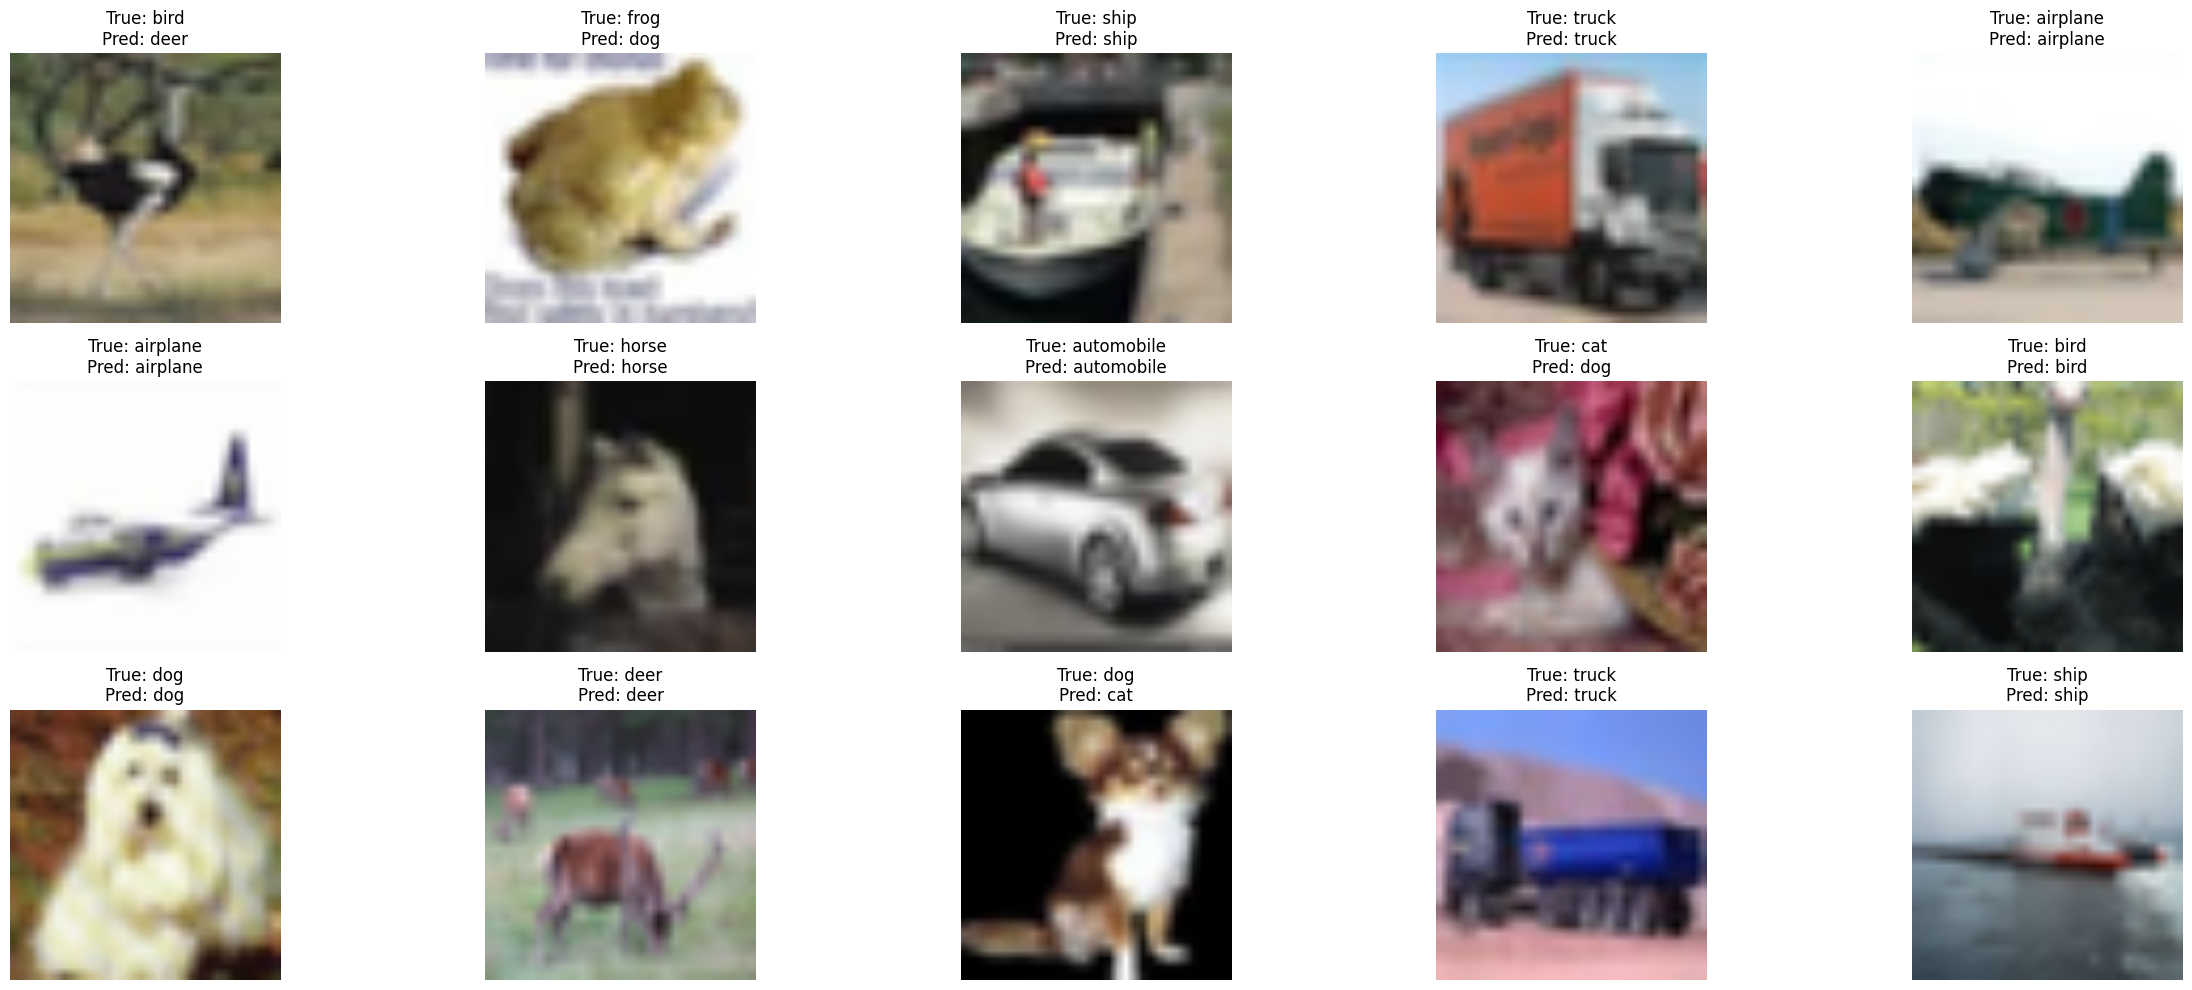

In [9]:
def display_predictions(model, test_images, test_labels, class_names, num_samples=15):
    plt.figure(figsize=(25, 10))

    for i in range(num_samples):
        # Randomly select an image from the test set
        idx = np.random.randint(0, len(test_images))
        img = test_images[idx]
        true_label = test_labels[idx]

        # Ensure true_label is an integer scalar
        if not isinstance(true_label, int):
            true_label = true_label.item()  # Convert scalar array or tensor to integer

        # Resize the image to 224x224 to match model input shape
        resized_img = tf.image.resize(img, (224, 224)).numpy()

        # Get the model's prediction
        prediction = model.predict(tf.expand_dims(resized_img, axis=0), verbose=0)
        predicted_class = np.argmax(prediction, axis=1)[0]

        # Display the image with true and predicted labels
        plt.subplot(3, 5, i + 1)
        plt.imshow(img)  # Show the original image
        plt.axis('off')
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[predicted_class]}")

    plt.tight_layout()
    plt.show()


# CIFAR-10 labels
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Show predictions
display_predictions(vision_transformer_model, test_images, test_labels, class_names, num_samples=15)


**Training and validation metrics for ViT Model**

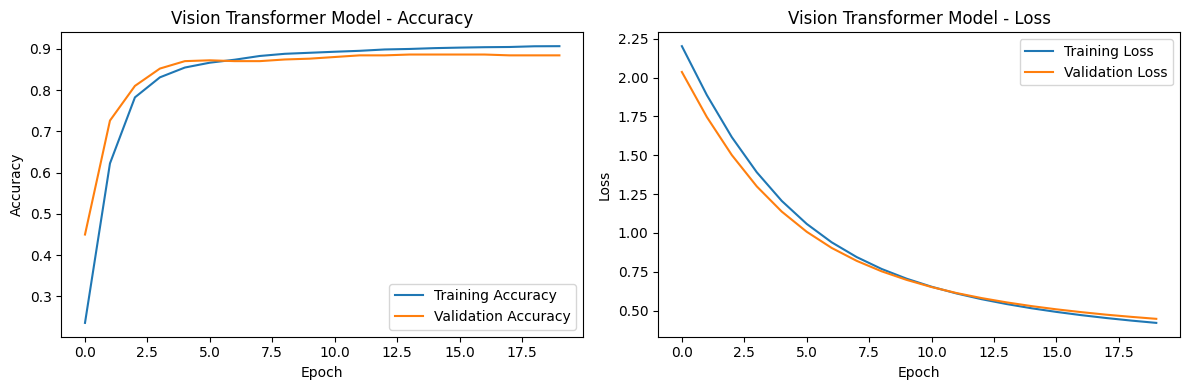

In [10]:
def plot_training_metrics(history, model_name):
    plt.figure(figsize=(12, 4))

    # accuracy plot is this below:-
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"{model_name} - Accuracy")

    # loss plot is this below:-
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{model_name} - Loss")

    plt.tight_layout()
    plt.show()

plot_training_metrics(training_history_vit, "Vision Transformer Model")


# **3. Hybrid VGG16 + ViT Model below:-**

In [11]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformation
# Adjusted transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=20),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


dataset = CIFAR10(root='./data', train=True, download=True, transform=None)
images = dataset.data
labels = np.array(dataset.targets)


train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)


def create_dataloader(images, labels, transform, batch_size=32):
    images = torch.tensor(images).permute(0, 3, 1, 2)  # Convert to PyTorch format
    labels = torch.tensor(labels)
    dataset = TensorDataset(images, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

from torch.utils.data.sampler import WeightedRandomSampler

class_sample_count = np.array([sum(train_labels == i) for i in range(10)])
weights = 1. / class_sample_count
samples_weight = np.array([weights[t] for t in train_labels])
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler)


train_loader = create_dataloader(train_images, train_labels, transform_train, batch_size=128)
val_loader = create_dataloader(val_images, val_labels, transform_val, batch_size=128)
test_loader = create_dataloader(test_images, test_labels, transform_val, batch_size=128)

class FeatureExtractor(nn.Module):
    def __init__(self, pretrained_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            pretrained_model.features[:17],
            nn.BatchNorm2d(256),  # Add batch normalization
        )
        self.dropout = nn.Dropout(0.75)  # Increased dropout
        self.conv = nn.Conv2d(256, 3, kernel_size=1)
        self.adapt_pool = nn.AdaptiveAvgPool2d((224, 224))

    def forward(self, x):
        x = self.features(x)
        x = self.dropout(x)
        x = self.conv(x)
        x = self.adapt_pool(x)
        return x



# Hybrid VGG16 + ViT model
class HybridVGG16ViT(nn.Module):
    def __init__(self):
        super(HybridVGG16ViT, self).__init__()
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        for param in vgg16.features[:10].parameters():
            param.requires_grad = False
        self.feature_extractor = FeatureExtractor(vgg16)

        # Configure ViT with the correct number of classes
        self.vit = ViTForImageClassification.from_pretrained(
            'google/vit-large-patch16-224-in21k',
            num_labels=10  # CIFAR-10 has 10 classes
        ).to(device)

    def forward(self, x):
        x = self.feature_extractor(x)  # Output shape: [batch_size, 3, 224, 224]
        return self.vit(pixel_values=x).logits

import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        p_t = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return focal_loss.mean()


100%|██████████| 170M/170M [00:03<00:00, 49.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


**Training the model**

In [13]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)



model = HybridVGG16ViT().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        score = val_accuracy
        if self.best_score is None or score > self.best_score:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# Training function with correct loss logging and processing
# Training function with correct loss logging and processing
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, model_path="best_model.pth"):
    best_val_accuracy = -float('inf')
    scaler = GradScaler()
    early_stopping = EarlyStopping(patience=10)
    training_stats = {"train_accuracy": [], "val_accuracy": [], "train_loss": [], "val_loss": []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.float().to(device), labels.to(device)
            optimizer.zero_grad()

            # Enable mixed precision training
            with autocast():  # Updated to match older PyTorch versions
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backpropagation
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = 100 * train_correct / total
        train_loss /= total

        model.eval()
        val_loss, val_correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.float().to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)


                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = 100 * val_correct / total
        val_loss /= total

        # Learning rate adjustment
        scheduler.step(val_accuracy)

        # save the best model as perthe validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), model_path)
            print(f"Epoch {epoch + 1}: val_accuracy improved to {val_accuracy:.5f}, saving model.")

        # Logging epoch results
        print(f"Train Acc: {train_accuracy:.2f}%, Train Loss: {train_loss:.4f}")
        print(f"Val Acc: {val_accuracy:.2f}%, Val Loss: {val_loss:.4f}")

        # training stats for req 4 plots
        training_stats["train_accuracy"].append(train_accuracy)
        training_stats["val_accuracy"].append(val_accuracy)
        training_stats["train_loss"].append(train_loss)
        training_stats["val_loss"].append(val_loss)

        # Early stopping check
        if early_stopping(val_accuracy):
            print("Early stopping triggered.")
            break

    return training_stats

training_stats = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-315016644a39>:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/20



Training:   0%|          | 0/313 [00:00<?, ?it/s]<ipython-input-13-315016644a39>:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated to match older PyTorch versions
Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 1: val_accuracy improved to 57.56000, saving model.
Train Acc: 35.40%, Train Loss: 1.6745
Val Acc: 57.56%, Val Loss: 1.1617
Epoch 2/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 2: val_accuracy improved to 65.52000, saving model.
Train Acc: 59.16%, Train Loss: 1.1203
Val Acc: 65.52%, Val Loss: 0.9560
Epoch 3/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 3: val_accuracy improved to 70.34000, saving model.
Train Acc: 65.97%, Train Loss: 0.9377
Val Acc: 70.34%, Val Loss: 0.8322
Epoch 4/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 4: val_accuracy improved to 71.26000, saving model.
Train Acc: 68.54%, Train Loss: 0.8752
Val Acc: 71.26%, Val Loss: 0.8071
Epoch 5/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 5: val_accuracy improved to 71.32000, saving model.
Train Acc: 69.03%, Train Loss: 0.8609
Val Acc: 71.32%, Val Loss: 0.8025
Epoch 6/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 6: val_accuracy improved to 71.92000, saving model.
Train Acc: 69.08%, Train Loss: 0.8548
Val Acc: 71.92%, Val Loss: 0.7906
Epoch 7/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 7: val_accuracy improved to 72.08000, saving model.
Train Acc: 69.61%, Train Loss: 0.8450
Val Acc: 72.08%, Val Loss: 0.7864
Epoch 8/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 8: val_accuracy improved to 72.66000, saving model.
Train Acc: 70.04%, Train Loss: 0.8318
Val Acc: 72.66%, Val Loss: 0.7771
Epoch 9/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 9: val_accuracy improved to 72.82000, saving model.
Train Acc: 70.43%, Train Loss: 0.8217
Val Acc: 72.82%, Val Loss: 0.7752
Epoch 10/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 10: val_accuracy improved to 73.08000, saving model.
Train Acc: 71.11%, Train Loss: 0.8006
Val Acc: 73.08%, Val Loss: 0.7490
Epoch 11/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 11: val_accuracy improved to 74.04000, saving model.
Train Acc: 72.02%, Train Loss: 0.7829
Val Acc: 74.04%, Val Loss: 0.7364
Epoch 12/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 12: val_accuracy improved to 75.14000, saving model.
Train Acc: 72.49%, Train Loss: 0.7697
Val Acc: 75.14%, Val Loss: 0.7235
Epoch 13/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 13: val_accuracy improved to 76.22000, saving model.
Train Acc: 73.36%, Train Loss: 0.7479
Val Acc: 76.22%, Val Loss: 0.6882
Epoch 14/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Train Acc: 73.78%, Train Loss: 0.7350
Val Acc: 74.74%, Val Loss: 0.7106
Epoch 15/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 15: val_accuracy improved to 77.94000, saving model.
Train Acc: 76.09%, Train Loss: 0.6733
Val Acc: 77.94%, Val Loss: 0.6421
Epoch 16/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Train Acc: 76.27%, Train Loss: 0.6731
Val Acc: 77.84%, Val Loss: 0.6545
Epoch 17/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Train Acc: 77.55%, Train Loss: 0.6304
Val Acc: 77.16%, Val Loss: 0.6656
Epoch 18/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 18: val_accuracy improved to 78.06000, saving model.
Train Acc: 79.31%, Train Loss: 0.5857
Val Acc: 78.06%, Val Loss: 0.6605
Epoch 19/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 19: val_accuracy improved to 78.64000, saving model.
Train Acc: 79.97%, Train Loss: 0.5653
Val Acc: 78.64%, Val Loss: 0.6210
Epoch 20/20


Validation: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 20: val_accuracy improved to 79.90000, saving model.
Train Acc: 81.21%, Train Loss: 0.5348
Val Acc: 79.90%, Val Loss: 0.6188


**predict the model on test images for VGG16 + ViT model**

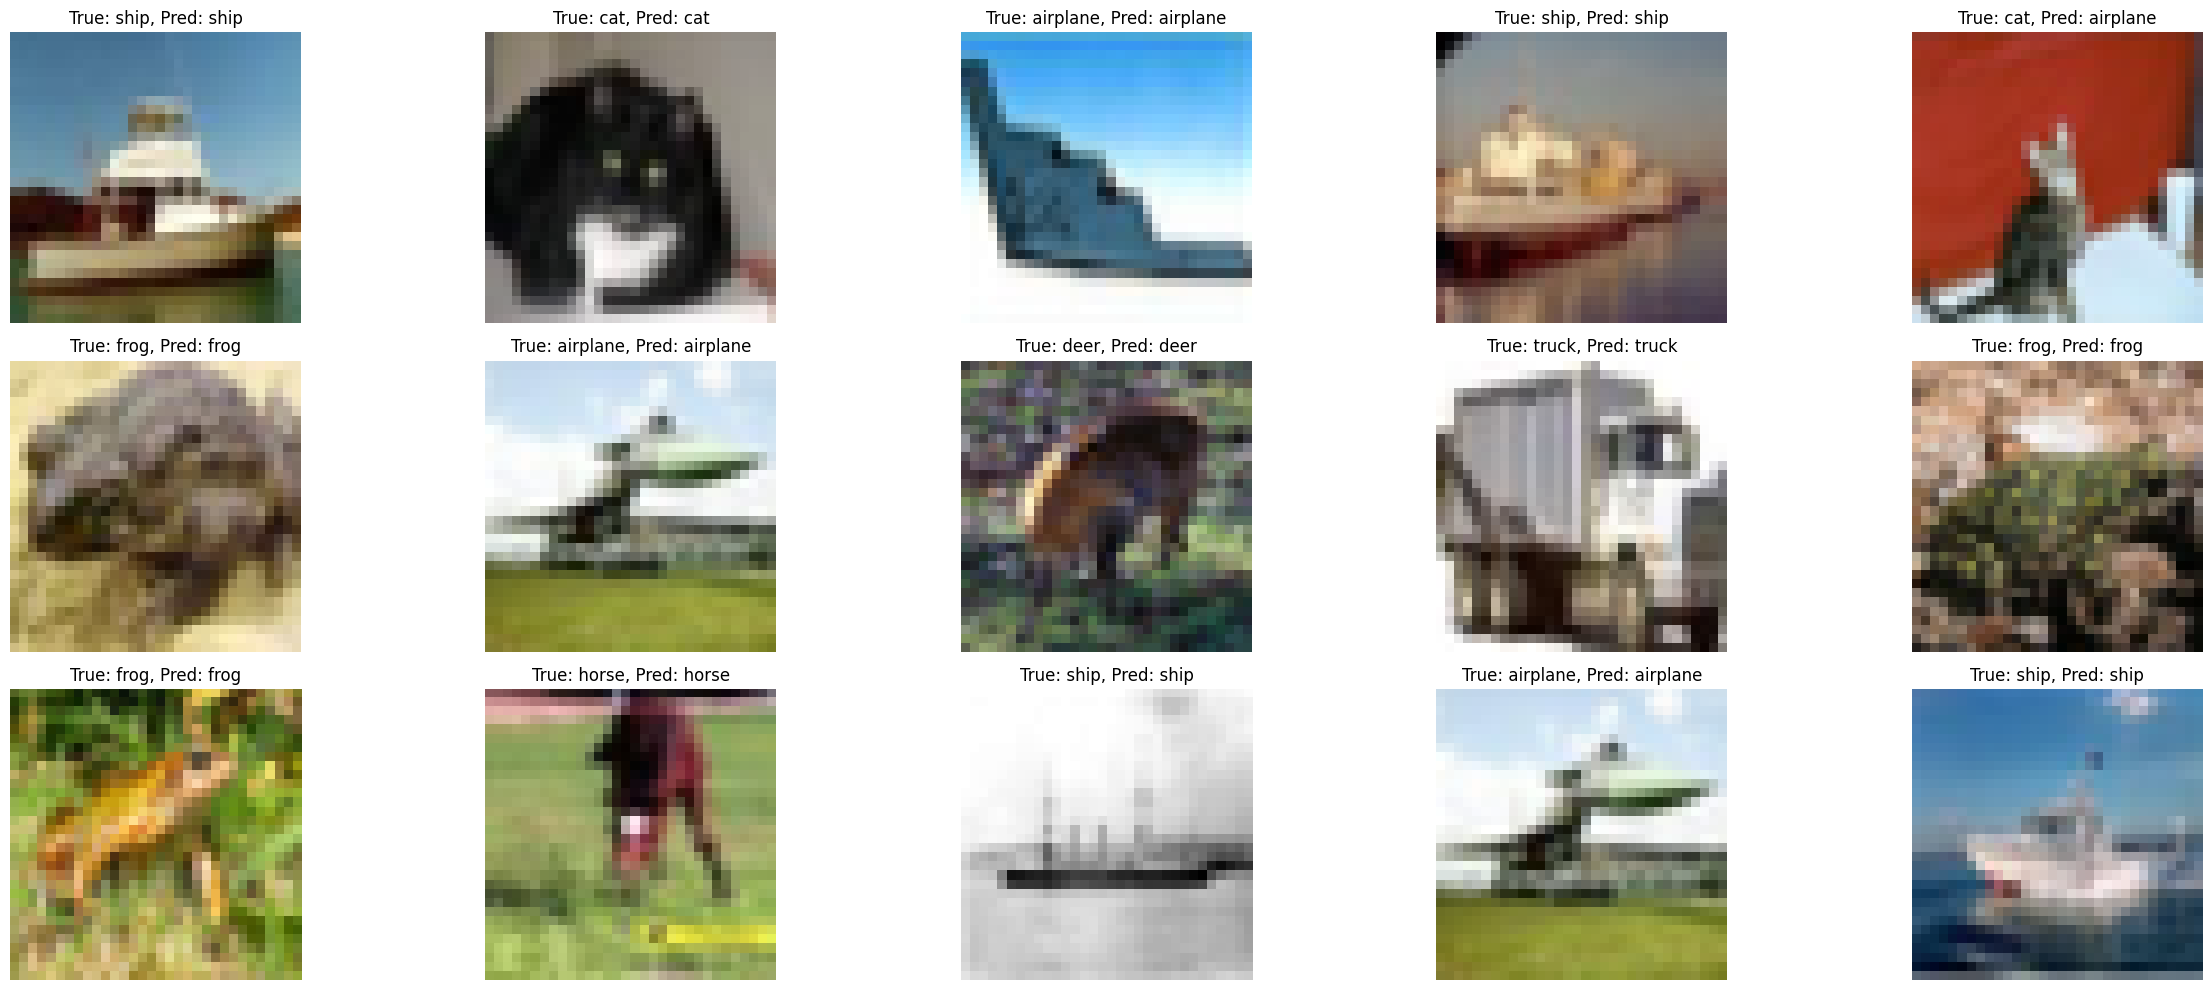

In [14]:
def display_predictions(model, test_loader, class_names, num_samples=15):
    model.eval()

    images, labels = next(iter(test_loader))
    images, labels = images.float().to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        predictions = torch.argmax(outputs, axis=1)

    plt.figure(figsize=(25, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))

        img = images[idx].cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())

        true_label = labels[idx].item()
        predicted_label = predictions[idx].item()

        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {class_names[true_label]}, Pred: {class_names[predicted_label]}")

    plt.tight_layout()
    plt.show()

# CIFAR-10 labels
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Call the function
display_predictions(model, test_loader, class_names, num_samples=15)


**Training and Validation metrics for VGG16 + ViT Model:-**

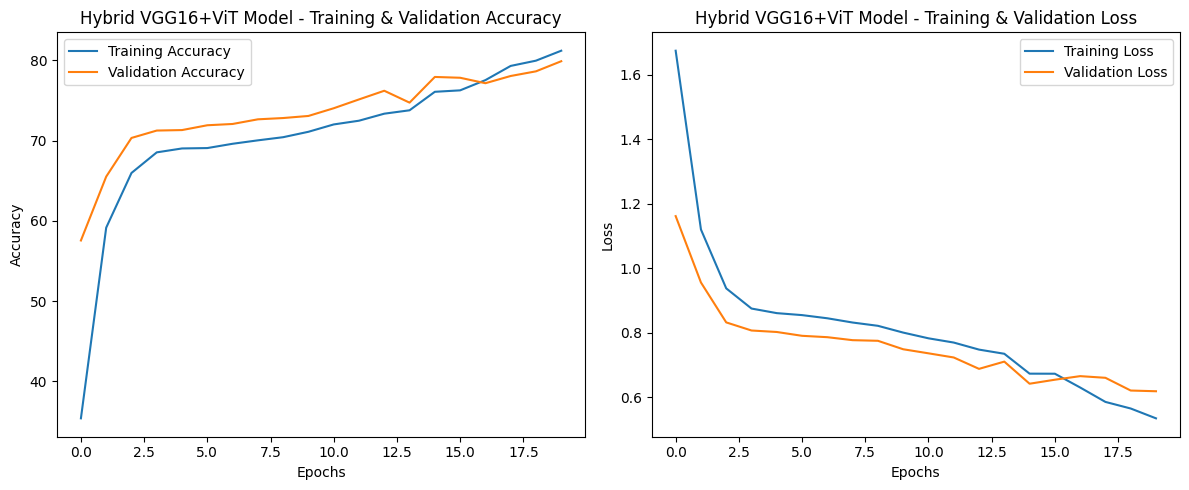

In [16]:
def plot_training_metrics(training_stats, model_name):
    required_keys = ["train_accuracy", "val_accuracy", "train_loss", "val_loss"]
    missing_keys = [key for key in required_keys if key not in training_stats]
    if missing_keys:
        raise ValueError(f"Missing keys in training_stats: {missing_keys}")

    # Plot Training & Validation Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_stats["train_accuracy"], label="Training Accuracy")
    plt.plot(training_stats["val_accuracy"], label="Validation Accuracy")
    plt.title(f"{model_name} - Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(training_stats["train_loss"], label="Training Loss")
    plt.plot(training_stats["val_loss"], label="Validation Loss")
    plt.title(f"{model_name} - Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_metrics(training_stats, "Hybrid VGG16+ViT Model")


# **4. Analysis and Comparison below:-**

**4.1 Performance Analysis**

In [17]:
def plot_comparison(training_history_vit, training_stats, vit_label="ViT", hybrid_label="VGG16+ViT"):
    # Extract data for Vision Transformer
    vit_epochs = range(1, len(training_history_vit.history['accuracy']) + 1)
    vit_train_accuracy = [acc * 100 for acc in training_history_vit.history.get('accuracy', [])]
    vit_val_accuracy = [acc * 100 for acc in training_history_vit.history.get('val_accuracy', [])]
    vit_train_loss = training_history_vit.history.get('loss', [])
    vit_val_loss = training_history_vit.history.get('val_loss', [])

    # Extract data for Hybrid Model
    hybrid_epochs = range(1, len(training_stats.get('train_accuracy', [])) + 1)
    hybrid_train_accuracy = training_stats.get('train_accuracy', [])
    hybrid_val_accuracy = training_stats.get('val_accuracy', [])
    hybrid_train_loss = training_stats.get('train_loss', [])
    hybrid_val_loss = training_stats.get('val_loss', [])

    # Ensure no mismatched lengths for plotting
    if not vit_train_accuracy or not hybrid_train_accuracy:
        print("Error: One or more training metrics are empty.")
        return

    plt.figure(figsize=(12, 5))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    if vit_train_accuracy:
        plt.plot(vit_epochs, vit_train_accuracy, 'r-', label=f"{vit_label} Training Acc")
        plt.plot(vit_epochs, vit_val_accuracy, 'r--', label=f"{vit_label} Validation Acc")
    if hybrid_train_accuracy:
        plt.plot(hybrid_epochs, hybrid_train_accuracy, 'b-', label=f"{hybrid_label} Training Acc")
        plt.plot(hybrid_epochs, hybrid_val_accuracy, 'b--', label=f"{hybrid_label} Validation Acc")
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    if vit_train_loss:
        plt.plot(vit_epochs, vit_train_loss, 'r-', label=f"{vit_label} Training Loss")
        plt.plot(vit_epochs, vit_val_loss, 'r--', label=f"{vit_label} Validation Loss")
    if hybrid_train_loss:
        plt.plot(hybrid_epochs, hybrid_train_loss, 'b-', label=f"{hybrid_label} Training Loss")
        plt.plot(hybrid_epochs, hybrid_val_loss, 'b--', label=f"{hybrid_label} Validation Loss")
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


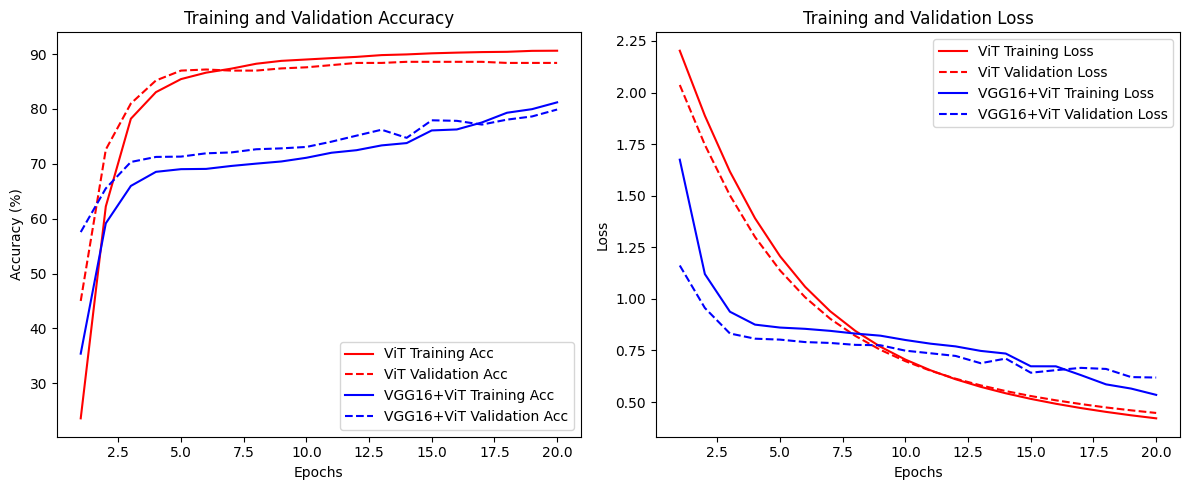

In [18]:
plot_comparison(training_history_vit, training_stats)

**Explanation based on above results:-**<br>

# Note:
<b>All the models were trained and tested on A100 collab GPU and the below results and discussions are as per that GPU.</b>


ViT has faster training time which is almost 4 seconds/epoch while VGG16 + ViT hybrid model has 2.5 minutes/epoch. <br><br>



**4.2: Discussion:-**

ViT directly processes the image patches and uses its transformers layers effectively for the image classification. On the oher hand VGG16 + ViT hybrid model adds additional convolutional layers that adds extra parameters which makes a direct impact on and thus result in slower learning rate. As ViT model reached its validation accuracy from 45% to 90% in 20 epochs while VGG16 + ViT hybrid model in the same number of epochs reached from 57% to 79.9%. <br><br>
ViT was significantly faster compared to VGG16 + ViT hybrid model whic makes it a better choice in scenarios where model requires rapid iteration and experimentation.<br><br>
ViT's self-attention is mostly based on matrix operations, which scale well with GPU optimisation.
Longer training times result from the computationally costly convolutional procedures used in hybrid VGG16 + ViT.<br><br>
Because the hybrid model had more convolutional layers, its memory footprint and complexity had increased.<br><br>


**Suggestions for performance improvement:-**

**Hybrid VGG16 + ViT:** Adjust extra layers in the VGG16 backbone for Hybrid VGG16 + ViT to maximise the use of pre-trained weights. To lessen overfitting, add dropout to the hybrid model.
Use weight decay as a test to enhance generalisation. To enhance model generalisation, use further augmentation methods like rotation, random cropping, or colour jitter. To better meet the needs of the hybrid model, modify batch sizes, optimiser parameters, and learning rates.

**ViT:** Unfreeze and adjust particular transformer layers on the downstream task for ViT.